# compose visualisations of listerner experience paper

In [9]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import librosa
from IPython.display import Audio
import mir_eval.sonify
from pydub import AudioSegment
from matplotlib.transforms import ScaledTranslation


from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [11]:
%load_ext autoreload
%autoreload 1
%aimport rp2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
 %reload_ext autoreload

In [13]:
def Part_maps(Entries):
    parts_on = {}
    cols = Entries.columns
    for c in cols:
        if Entries[c].isna().sum()>1:
            Entries.loc[Entries[c].notna(),['mm',c]]
            V = Entries.loc[Entries[c].notna(),['mm',c]]
            parts_on[c]=V.rename(columns = {c:'Playing'})
            D = pd.DataFrame(index = parts_on[c].index )
            for i in D.index:
                if parts_on[c].loc[i,'Playing'] == 1.0:
                    D[i] = D.index-i
            D[D>=0] = np.nan
            D['Pre'] = D.max(axis=1)
            D.loc[parts_on[c].loc[:,'Playing'] == 1.0,'Pre'] = 0.0
            parts_on[c]['Pre'] = D['Pre']
            parts_on[c]['Post'] = parts_on[c]['Pre'].diff()
            parts_on[c].loc[parts_on[c]['Post']<=0,'Post'] = 0.0
            parts_on[c][parts_on[c].isna()] = 0.0
    return parts_on
def resp_shade(ax,breaths,cat,colour):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Period_T'], facecolor=colour,alpha = 0.2)
    return

def resp_shaded(ax,breaths,cat,colour,alph = 0.4):
    # shading plots
    resps_to_shade = breaths.query('Categories==@cat')
    for i,r in resps_to_shade.iterrows():
        ax.axvspan(r['In'],r['In']+r['Insp_T'], facecolor=colour,alpha = alph )
        ax.axvspan(r['Ex'],r['Ex']+r['Exp_T'], facecolor=colour,alpha = alph - 0.2)
    return

def quickcarresp(Breaths):
    Insp_seq = Breaths.copy()#.query('In > @xlim[0] and In < @xlim[1]').copy().reset_index(drop=True)
    Insp_seq.loc[:,'dPT'] = np.log(Insp_seq['Period_T']/Insp_seq['Period_T'].shift(1)).abs()
    Insp_seq.loc[:,'dIT'] = np.log(Insp_seq['Insp_T']/Insp_seq['Insp_T'].shift(1)).abs()
    Insp_seq.loc[:,'dID'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].shift(1)).abs()
    Insp_seq.loc[:,'relD'] = np.log(Insp_seq['IDepth']/Insp_seq['IDepth'].rolling(5,center=True).median()).abs()
    
    depth_thresh = Insp_seq['IDepth'].median()*2
    low_D =  Insp_seq['IDepth'].quantile(0.25)
    mD =  Insp_seq['IDepth'].median()
    mT =  Insp_seq['Period_T'].median() 
    mIT =  Insp_seq['Insp_T'].median()
    
    Insp_seq['Categories']='Disturbed'

    V =  Insp_seq.query('Insp_T>0.5 and Period_T>2 and IDepth<3*@low_D and IE_Ratio>0.2 and dPT<0.5 and dID<0.5')
    Insp_seq.loc[V.index,'Categories']='Quiet'
    
    return Insp_seq

def minT(timestamps,timepoints):
    df = pd.DataFrame(index=timestamps,columns=['minT'],data = 0.0)
    for i in timestamps:
        df.loc[i,'minT']=(timepoints-i).abs().min()
    return df

## SSOdata

In [15]:
# audio file locations in
data_loc = './data/'
mydpi = 196

In [16]:
Pentries = pd.read_csv(data_loc +'Performance_data/PlayTimings_Lydo2024 - C5_Saev_themes.csv') 
concert = 'C5'
buff = 10
s_time = -buff #C_times.loc[0,concert]
e_time = Pentries[concert].iloc[-1]+buff
dur = (e_time - s_time)-2*buff
ev = {}
ev['Event'] = 'Kjempeviseslåtten'
ev['Related'] = 'Saev'

In [18]:
piece = ev['Related']
Pstructures = Pentries.loc[Pentries['Structure'].notna(),:]
Prehearse = Pentries.loc[Pentries['RehNo'].notna(),:]
annotations = pd.read_csv(data_loc + 'Annotations/Case1_Resp_Notes.csv')
entry_list = [7,9,10,11,12,14,15,16,19,20,21,25] #6,
restBreath_list = [17,29]
norest_list = [22,23,26,28]
Prehearse

,C5,mm,mm_original,RehNo,Structure,Theme,Conductor,Flute_1,Flute_2,Oboe_1,...,Perc_GC,Harp,Vn_solo,Violin_1,Violin_2,Va_solo,Viola,Vc_Solo,Cello,Contrabass
0,-0.328646,0.5,50.33,5.0,NaN,NaN,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,25.032667,9.0,59.00,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14,44.053333,17.0,67.00,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,62.541333,25.0,75.00,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,81.200667,33.0,83.00,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,99.400667,41.0,91.00,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN
40,117.032667,49.0,99.00,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
43,133.805333,57.0,107.00,12.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
51,150.752000,65.0,115.00,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,167.234667,73.0,123.00,14.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## phase alignment

In [19]:
# Sensor measurements
df_feats= pd.read_csv(data_loc + 'Physiological_data/Case1_Saev_Feats.csv',index_col=0)
Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(df_feats.loc[:,'Resp_wave']),df_feats.loc[:,'Resp_wave'])
Insp_seq = quickcarresp(Breaths)
R = (df_feats.loc[:,'Resp_wave']-df_feats.loc[:,'Resp_wave'].median())/Insp_seq['IDepth'].median()
df_feats.loc[:,'Resp_wave'] = R

In [22]:
sig = 'IminT'
df_feats[sig]= minT(df_feats.index,Breaths['In'])['minT'].values
sig = 'EminT'
df_feats[sig]= minT(df_feats.index,Breaths['Ex'])['minT'].values


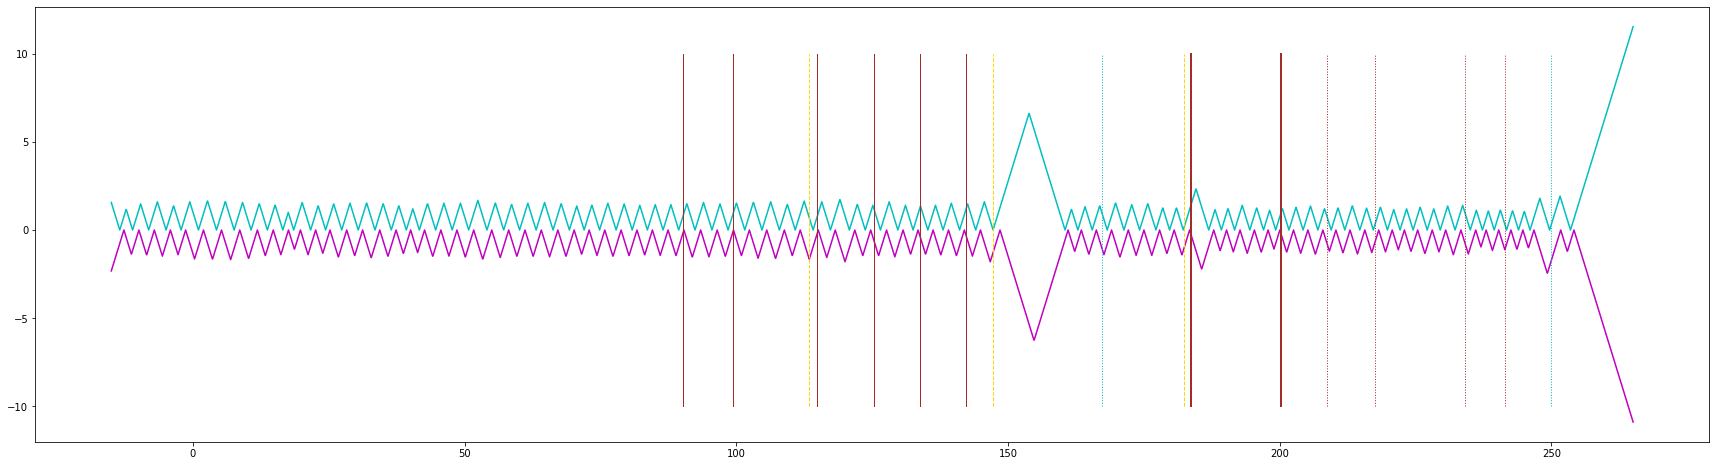

In [204]:
ax = df_feats['IminT'].plot(figsize=[10,8],color='c')
(-df_feats['EminT']).plot(ax=ax,color='m')
yrange = [-10,10]
tcue_list = [8,13,18]
lowpart_downbeatACCphrase = [6,7,9,10,11,12] #6,7 # ,14,15,16 20,25
entry_melody = [19,21] 
restBreath_list = [17,29]
norest_list = [22,23,26,28]
for tcue in annotations.loc[tcue_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold')   
for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
for tcue in annotations.loc[entry_melody,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
for tcue in annotations.loc[norest_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')
for tcue in annotations.loc[restBreath_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='c')

plt.show()


In [205]:
entry_list = [6,7,9,10,11,12,19,21] #6,7 # ,14,15,16 20,25 


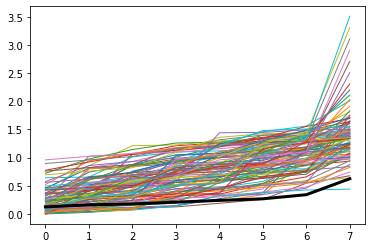

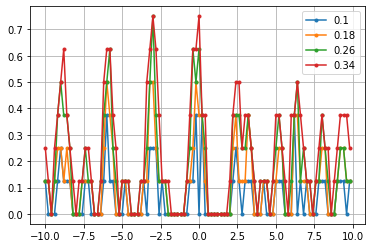

In [206]:
thresh = 0.1
threshrange = np.round(np.arange(0.1,0.4,0.08),2)
f = interpolate.interp1d(df_feats.index, df_feats['EminT'],fill_value='extrapolate')
prox = pd.DataFrame(index = np.arange(-10,10,0.2),columns=threshrange)
for delta in prox.index:
    C = f(annotations.loc[entry_list,'TIME']+delta)
    C = pd.Series(C).sort_values().reset_index(drop=True)
    C.plot(linewidth=1)
    for thresh in threshrange:
        prox.loc[delta,thresh]=(C<thresh).sum()/len(C)
C = f(annotations.loc[entry_list,'TIME'])
C = pd.Series(C).sort_values().reset_index(drop=True)
C.plot(label='Entries',c='k',linewidth=3)
plt.show()
prox.plot(kind='line',marker='.')
plt.grid()
plt.show()

In [207]:
annotations

,TIME,LABEL
0,25.045333,"9.0, Horn on beat acc"
1,34.645333,"13.0, Harp on beat acc"
2,53.546667,"21.0, no bass in downbeat acc"
3,62.560000,"25.0, no bass in downbeat acc"
4,72.053333,"29.0, no bass in downbeat acct"
5,81.152000,"33.0, no bass, Winds on beat acc"
6,90.197333,"37.0, Winds + cello solo on beat acc"
7,99.370667,"41.0, Los stings on beat acc"
8,113.322667,"47.25, Trumpet call"
9,114.858667,"48.0, Bass on beat acc (entry 1m earlier)"


In [208]:
audio_loc

'/Users/finn/Desktop/Current_Projects/Stavanger/Data2024/Audio/Piece_wise/'

In [209]:
# Audio recording and features
aud_file = audio_loc +'C5_' + ev["Related"]+'_10.mp3' #C1_Sae1_1.mp3
y, sr = librosa.load(aud_file)
rms =librosa.feature.rms(y=y, frame_length=256, hop_length=64, center=True, pad_mode='constant')
times = librosa.times_like(rms,sr = sr, hop_length=64)
rms_sf = int(sr/64)
aud_df = pd.DataFrame(index = times-1 ) # + M_times.loc[segtag,'Start']
aud_df['rms'] = rms[0]

buff = 10
C = librosa.cqt(y=y, sr=sr)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)
times = (-buff+np.arange(len(C_db[0]))*((2*buff)+dur)/len(C_db[0])).round(3)
pitchticks = np.arange(7,84,12)
pitchticklabels=['C1','C2','C3','C4','C5','C6','C7']
C_df = pd.DataFrame(data=C_db).transpose()
C_df = C_df[C_df.columns[::-1]]
C_df.set_index(times,inplace = True)

In [210]:
aud_file

'/Users/finn/Desktop/Current_Projects/Stavanger/Data2024/Audio/Piece_wise/C5_Saev_10.mp3'

In [211]:
# labelse and categories
palettes = ['c','m','g','r','b','k']
player = 'AU801'
respcats = ['Disturbed','Quiet']
palette={'Disturbed':'c','Quiet':'lightblue'}
# PartPalette = {'AU801_Saev1':'k','AU815_Saev2':'grey','VN101_Saev1':'orange'}
pitchticks = np.arange(7,84,12)
pitchticklabels=['C1','C2','C3','C4','C5','C6','C7']

In [212]:
buff = 10
s_time = -buff
e_time = dur+buff
frameN = len(C_df.loc[s_time:e_time,:])

# np.linspace(0, frameN - 1,frameN,dtype='int')
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
xticks = f(annotations['TIME'])
xticklabels = annotations['LABEL']

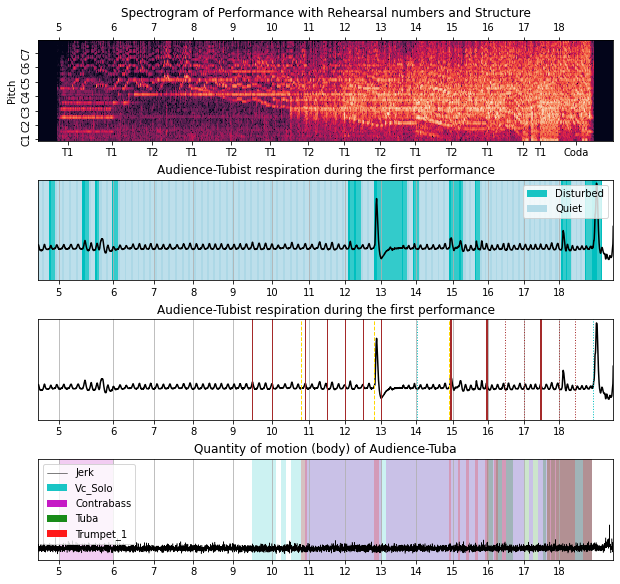

In [214]:
fig3 = plt.figure(constrained_layout=True,figsize=(8.5,8))
gs = fig3.add_gridspec(4, 3)
axes={}
axes[0] = fig3.add_subplot(gs[0, :])
axes[1] = fig3.add_subplot(gs[1, :])
axes[2] = fig3.add_subplot(gs[2, :])
axes[3] = fig3.add_subplot(gs[3, :])

ax=axes[0]
ax.set(title='Spectrogram of Performance with Rehearsal numbers and Structure')
chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
xticks = f(Pstructures.loc[:,'C5'])
xticklabels = Pstructures.loc[:,'Structure']
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel('Pitch')  
ax1 = ax.twiny()
ax1.set_xlim([-buff,dur+buff])
ax1.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
chart.set_yticks([83,71,59,47,35,23,11])
chart.set_yticklabels(pitchticklabels)
# ax1.set(xticks = Pthemes.loc[:,'C1_Sae1'],xticklabels=Pthemes.loc[:,'Theme'])


resprange = [-7,15]
s_time = -buff
e_time = dur+buff
ax=axes[1]
ax.set_title('Audience-Tubist respiration during the first performance')
df_feats.loc[:,'Resp_wave'].plot(c='k',linestyle='-',label="",ax = ax)
for cat in respcats: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
ax.legend(loc='upper right') #loc='upper right'
for cat in respcats: #'Vocal?',
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()

ax=axes[2]
ax.set_title('Audience-Tubist respiration during the first performance')
df_feats.loc[:,'Resp_wave'].plot(c='k',linestyle='-',label="",ax = ax)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()

yrange = resprange
tcue_list = [8,13,18]
lowpart_downbeatACCphrase = [6,7,9,10,11,12,14] #6,7 # ,14,15,16 20,25
entry_melody = [19,21,25] 
restBreath_list = [17,29]
norest_list = [22,23,26,28]
for tcue in annotations.loc[tcue_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold')   
for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
for tcue in annotations.loc[entry_melody,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
for tcue in annotations.loc[norest_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')
for tcue in annotations.loc[restBreath_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='c')

ax=axes[3]
ax.set_title('Quantity of motion (body) of Audience-Tuba')
df_feats.loc[:,'Jerk'].plot(c='k',linewidth=0.5,ax = ax)
ax.set(ylim=[0,100],xlim=[s_time,e_time],yticks=[],xlabel='')
# ax.set(xticks = Pstructures.loc[:,'C1_Sae1'],xticklabels=Pstructures.loc[:,'Structure'])
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()

palettes = ['c','m','g','r','b','k']
Pentries['Time_s'] = Pentries[concert]
Pentries = Pentries.set_index('Time_s',drop = True)
Part_entries = Part_maps(Pentries) 
parts= [ 'Vc_Solo','Contrabass','Tuba','Trumpet_1'] #['Clarinet_1','Trumpet_1']#
k = 0
for part in parts: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palettes[k],alpha = 0.9,label=part)
    k+=1
ax.legend(loc='upper left')

k = 0
for part in parts:
    Entries = Part_entries[part].copy() 
    es = Entries.index[Entries['Playing']==1.0]
    ee = Entries.index[Entries['Playing']==0.0]
    if len(ee)>len(es): ee = ee[1:]  
    for i in range(len(es)):
        ax.axvspan(es[i],ee[i], facecolor=palettes[k],alpha = 0.2)
    k+=1

outplots = './plots/'
figname = '_'.join(['Compound_Full',player,ev['Event']+'_2.png'])
plt.savefig(outplots+figname,bbox_inches = 'tight',dpi = 196)
plt.show()

In [215]:
ev['Event']

'Kjempervisesåtten'

In [216]:
dur + 2*buff

269.413

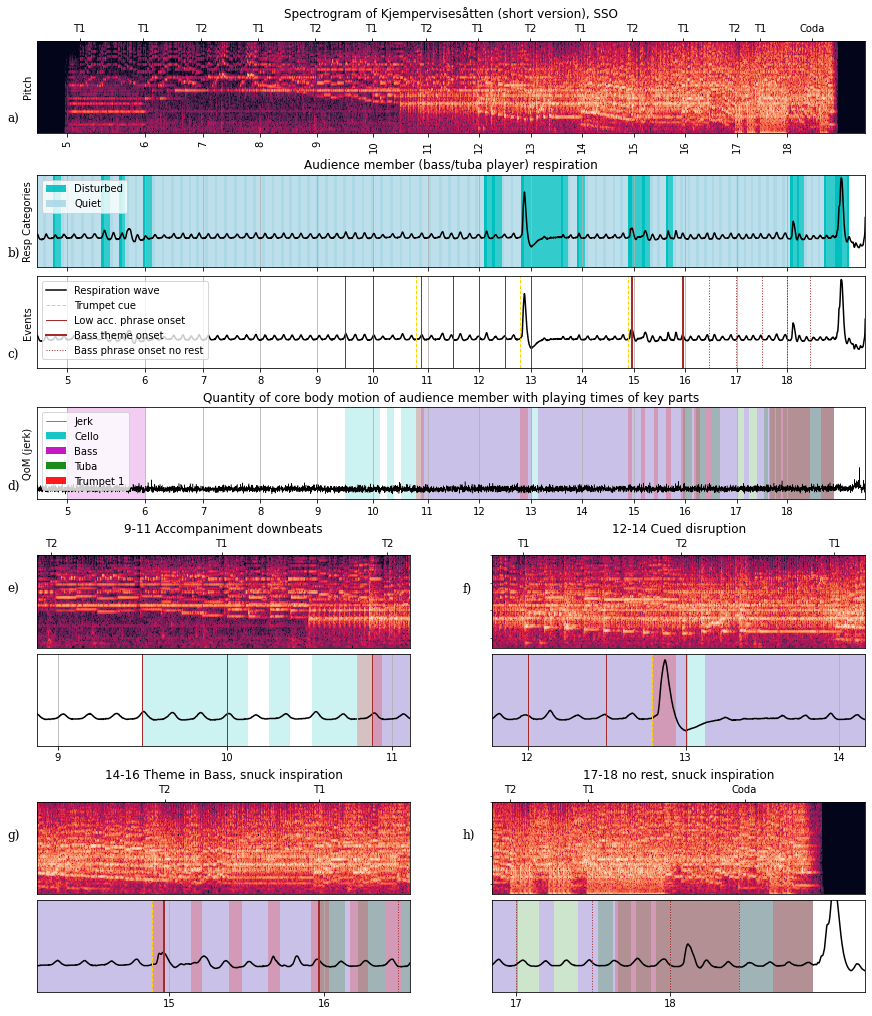

In [217]:
fig3 = plt.figure(constrained_layout=True,figsize=(12,14))
gs = fig3.add_gridspec(8, 2)
axes={}
axes[0] = fig3.add_subplot(gs[0, :])
axes[1] = fig3.add_subplot(gs[1, :])
axes[2] = fig3.add_subplot(gs[2, :])
axes[3] = fig3.add_subplot(gs[3, :])
axes[4] = fig3.add_subplot(gs[4,0])
axes[5] = fig3.add_subplot(gs[5,0])
axes[6] = fig3.add_subplot(gs[4,1])
axes[7] = fig3.add_subplot(gs[5,1])
axes[8] = fig3.add_subplot(gs[6,0])
axes[9] = fig3.add_subplot(gs[7,0])
axes[10] = fig3.add_subplot(gs[6,1])
axes[11] = fig3.add_subplot(gs[7,1])

s_time = -buff
e_time = dur+buff
ax=axes[0]
ax.set(title='Spectrogram of '+ev['Event']+' (short version), SSO') # with Rehearsal numbers and Structure
chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
frameN = len(C_df.loc[s_time:e_time,:])
t_C1 = list(C_df.loc[s_time:e_time,:].index)
t_Alt =  np.linspace(0, frameN - 1,frameN,dtype='int')
f = interpolate.interp1d(t_C1,t_Alt,fill_value='extrapolate',kind='linear')
ax.set(xticks = f(Prehearse.loc[:,'C5']),xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')),yticks=[])
ax.set_ylabel('Pitch')  
ax1 = ax.twiny()
ax1.set(xticks = Pstructures.loc[:,'C5'],xticklabels=Pstructures.loc[:,'Structure'])
ax1.set_xlim([s_time,e_time])

resprange = [-7,15]
ax=axes[1]
ax.set(title = 'Audience member (bass/tuba player) respiration',ylabel='Resp Categories')
df_feats.loc[:,'Resp_wave'].plot(c='k',linestyle='-',label="",ax = ax)
for cat in respcats: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palette[cat],alpha = 0.9,label=cat)
ax.legend(loc='upper left') #loc='upper right'
for cat in respcats: #'Vocal?',
    resp_shaded(ax,Insp_seq,cat,palette[cat],1.0)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=[])#(Prehearse.loc[:,'RehNo'].astype('int'))
ax.grid()

ax=axes[2]
df_feats.loc[:,'Resp_wave'].plot(c='k',linestyle='-',label="Respiration wave",ax = ax)
ax.set(ylim=resprange,xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()
# ax.set_title('Audience member respiration, events and phases')
ax.set(title = '',ylabel='Events')

yrange = resprange
ax.plot([-20, -20],yrange,linestyle = '--',linewidth=1,color='gold',label = "Trumpet cue")
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=1,color='brown',label = "Low acc. phrase onset") 
ax.plot([-20, -20],yrange,linestyle = '-',linewidth=2,color='brown',label = "Bass theme onset") 
ax.plot([-20, -20],yrange,linestyle = ':',linewidth=1,color='brown',label = "Bass phrase onset no rest") 
ax.legend(loc='upper left')
tcue_list = [8,13,18]
lowpart_downbeatACCphrase = [6,7,9,10,11,12,14] #6,7 # ,14,15,16 20,25
entry_melody = [19,21] 
norest_list = [22,23,26,25,26,28]
for tcue in annotations.loc[tcue_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold')   
for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
for tcue in annotations.loc[entry_melody,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
for tcue in annotations.loc[norest_list,'TIME']:
    ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')


ax=axes[3]
ax.set(title = 'Quantity of core body motion of audience member with playing times of key parts',ylabel = 'QoM (jerk)')
df_feats.loc[:,'Jerk'].plot(c='k',linewidth=0.5,ax = ax)
ax.set(ylim=[0,100],xlim=[s_time,e_time],yticks=[],xlabel='')
ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=(Prehearse.loc[:,'RehNo'].astype('int')))
ax.grid()

palettes = ['c','m','g','r','b','k']
Pentries['Time_s'] = Pentries[concert]
Pentries = Pentries.set_index('Time_s',drop = True)
Part_entries = Part_maps(Pentries) 
parts= [ 'Vc_Solo','Contrabass','Tuba','Trumpet_1'] #['Clarinet_1','Trumpet_1']#
parts_labels = {'Vc_Solo':'Cello','Contrabass':'Bass','Tuba':'Tuba','Trumpet_1':'Trumpet 1'}
k = 0
for part in parts: #'Vocal?',
    ax.axvspan(-20,-15, facecolor=palettes[k],alpha = 0.9,label=parts_labels[part])
    k+=1
ax.legend(loc='upper left')

k = 0
for part in parts:
    Entries = Part_entries[part].copy() 
    es = Entries.index[Entries['Playing']==1.0]
    ee = Entries.index[Entries['Playing']==0.0]
    if len(ee)>len(es): ee = ee[1:]  
    for i in range(len(es)):
        ax.axvspan(es[i],ee[i], facecolor=palettes[k],alpha = 0.2)
    k+=1
    
    
resprange = [-5,12]

intervals={
# "mm 33 No bass start ":[80,110],
"9-11 Accompaniment downbeats":[79,119],
"12-14 Cued disruption":[130,170],
"14-16 Theme in Bass, snuck inspiration":[170,210],
"17-18 no rest, snuck inspiration":[215,255] }

excerpts_Label=list(intervals.keys())
for i in range(4):
    exc = excerpts_Label[i]
    [s_time,e_time] = intervals[exc]
    
    ax = axes[(i*2)+4]
    chart = sns.heatmap(data=C_df.loc[s_time:e_time].transpose(),cmap="rocket",ax=ax,cbar = False)# ,'label': 'Expiration | Inspiration', ,cbar_kws={'ticks':[],'use_gridspec':False,'location':"top"}
    ax.set(xticks=[],xticklabels=[],yticks=[],yticklabels=[]) #,ylabel='Audio'
    ax.set_title(exc)
    ax1 = ax.twiny()
    ax1.set(xticks = Pstructures.loc[:,'C5'],xticklabels=Pstructures.loc[:,'Structure'])
    ax1.set_xlim([s_time,e_time])
    
    ax = axes[(i*2)+5]

    df_feats.loc[:,'Resp_wave'].plot(c='k',ax = ax)
    yrange = resprange
#     tcue_list = [8,13,18]
#     lowpart_downbeatACCphrase = [6,7,9,10,11,12,14] #6,7 # ,14,15,16 20,25
#     entry_melody = [19,21] 
#     norest_list = [22,23,26,28]
    for tcue in annotations.loc[tcue_list,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = '--',linewidth=1,color='gold')   
    for tcue in annotations.loc[lowpart_downbeatACCphrase ,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=1,color='brown')
    for tcue in annotations.loc[entry_melody,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = '-',linewidth=2,color='brown')
    for tcue in annotations.loc[norest_list,'TIME']:
        ax.plot([tcue, tcue],yrange,linestyle = ':',linewidth=1,color='brown')
  
    ax.set(xticks = Prehearse.loc[:,'C5'],xticklabels=Prehearse.loc[:,'RehNo'].astype('int'),yticks=[],yticklabels=[]) #,ylabel='Resp'
    ax.set(xlim =[s_time,e_time],xlabel='',ylim=resprange)
    ax.grid()
    
    k = 0
    for part in parts:
        Entries = Part_entries[part].copy() 
        es = Entries.index[Entries['Playing']==1.0]
        ee = Entries.index[Entries['Playing']==0.0]
        if len(ee)>len(es): ee = ee[1:]  
        for i in range(len(es)):
            ax.axvspan(es[i],ee[i], facecolor=palettes[k],alpha = 0.2)
        k+=1

ax_labels = ['a)','b)','c)','d)','e)','','f)','','g)','','h)','','i)','j)','k)','l)','m)','n)']
for i in range(len(axes)):
    ax = axes[i]
    label = ax_labels[i]
    if i<4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -85/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
    if i>=4:
        ax.text(0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(-30/72, -40/72, fig3.dpi_scale_trans)),
            fontsize='large', va='bottom', fontfamily='serif')
        
outplots = './plots/'
figname = '_'.join(['Compound_Excerpts',player,ev['Event']+'_3.png'])
plt.savefig(outplots+figname,bbox_inches = 'tight',dpi = 196)
plt.show()

# Resp cats for this piece

In [160]:
pwd

'/Users/finn/Desktop/Current_Projects/BiC/Audience_Interviewed/Analysis'

In [171]:
Insp_seq.query('Categories=="Quiet"').loc[:,'Period_T'].sum()/Insp_seq.loc[:,'Period_T'].sum()

0.7803137572202369

In [172]:
files = os.listdir('../SSO/Signals/Saev/EQRESP/')
ratios = []
for file in files:
    if 'AU8' in file:
        V = pd.read_csv('../SSO/Signals/Saev/EQRESP/'+file)
        V.set_index('p_sTime',inplace=True)
        Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(V['Breathing']),V['Breathing'])
        Insp_seq = quickcarresp(Breaths)
        Qratio = Insp_seq.query('Categories=="Quiet"').loc[:,'Period_T'].sum()/Insp_seq.loc[:,'Period_T'].sum()
        print([file,Qratio])
        ratios.append(Qratio)

['C7_Saev_AU819_EQRESP.csv', 0.5853369976004243]
['C5_Saev_AU811_EQRESP.csv', 0.7191512906621991]
['C7_Saev_AU814_EQRESP.csv', 0.7298128827314532]
['C5_Saev_AU808_EQRESP.csv', 0.7479767008208537]
['C5_Saev_AU802_EQRESP.csv', 0.6809721339956067]
['C7_Saev_AU816_EQRESP.csv', 0.11080843420831082]
['C5_Saev_AU807_EQRESP.csv', 0.06709918498249313]
['C7_Saev_AU813_EQRESP.csv', 0.4573610710241781]
['C5_Saev_AU804_EQRESP.csv', 0.5640951012315137]
['C5_Saev_AU809_EQRESP.csv', 0.742912245446281]
['C7_Saev_AU818_EQRESP.csv', 0.8123067477401507]
['C5_Saev_AU810_EQRESP.csv', 0.8874439660911633]
['C5_Saev_AU801_EQRESP.csv', 0.78648494747726]
['C7_Saev_AU815_EQRESP.csv', 0.7169957699909488]
['C5_Saev_AU806_EQRESP.csv', 0.5364575327023443]
['C7_Saev_AU812_EQRESP.csv', 0.7732453620475562]
['C5_Saev_AU803_EQRESP.csv', 0.6134778230918008]
['C7_Saev_AU817_EQRESP.csv', 0.7025959134570199]
['C7_Saev_AU820_EQRESP.csv', 0.5329896486324985]


0.7025959134570199

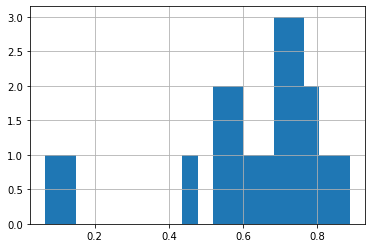

In [177]:
pd.Series(ratios).hist(bins=20)
pd.Series(ratios).median()

In [ ]:
df_feats= pd.read_csv('../SSO/Signals/AU801_Saev_Feats.csv',index_col=0)
Breaths = rp2.breath_cycles(rp2.EQ_Inspiration_Extract(df_feats.loc[:,'Resp_wave']),df_feats.loc[:,'Resp_wave'])
Insp_seq = quickcarresp(Breaths)
R = (df_feats.loc[:,'Resp_wave']-df_feats.loc[:,'Resp_wave'].median())/Insp_seq['IDepth'].median()
df_feats.loc[:,'Resp_wave'] = R

In [163]:
ratio_resp=pd.read_csv('/Users/finn/Desktop/Current_Projects/BiC/'+'Respiration_Musicians/OrchResp/outfiles/Audience_RespCat_SSO_2024.csv',index_col=0)

In [166]:
ratio_resp.query('PartID=="AU801" and Piece == "Saev" ')

,PartID,Piece,Perf,Type,Count,Ratio,Time_total,Time_Ratio,BR_LIST
100,AU801,Saev,C5,Quietish,61,0.670330,179.741,0.673359,1 -11.099\n2 -8.091\n4 -2.152\n5...
101,AU801,Saev,C5,Augmented,1,0.010989,13.204,0.049466,"54 147.272\nName: In, dtype: float64"


In [ ]:
67 %

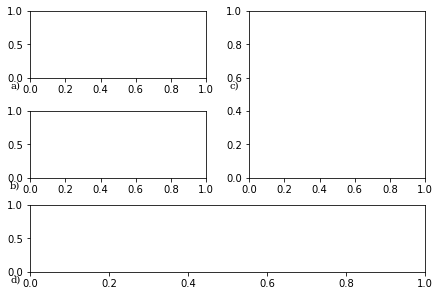

In [152]:

fig, axs = plt.subplot_mosaic([['a)', 'c)'], ['b)', 'c)'], ['d)', 'd)']],
                              layout='constrained')
for label, ax in axs.items():
    # Use ScaledTranslation to put the label
    # - at the top left corner (axes fraction (0, 1)),
    # - offset 20 pixels left and 7 pixels up (offset points (-20, +7)),
    # i.e. just outside the axes.
    ax.text(
        0.0, 1.0, label, transform=(
            ax.transAxes + ScaledTranslation(-20/72, -79/72, fig.dpi_scale_trans)),
        fontsize='medium', va='bottom', fontfamily='serif')